<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left">DISCOVERY DE DATOS</h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [1]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Expresiones regulares
import re

# Estadística inferencial
import scipy
from statsmodels.stats.weightstats import zconfint

## Importar DataSet
Una vez que hemos limpiado el dataset, realizamos el estudio descriptivo y discovery de los datos. Para ello, importamos el dataset limpio:

In [2]:
s3 = boto3.client("s3")

In [3]:
# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

In [4]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'df_clean.csv',Filename = '/tmp/df_clean.csv')

In [6]:
#Leemos el fichero y lo metemos en un dataframe.
df = pd.read_csv('/tmp/df_clean.csv', dtype={'rank':'category'})

Tomemos sensibilidad del dataframe de trabajo:

In [7]:
print("Tamaño dataset del dataset:", df.shape)
print("Número de variables/predictores (columnas):", df.shape[1])
print("Número de registros (instancias/filas):", df.shape[0])

Tamaño dataset del dataset: (6362620, 11)
Número de variables/predictores (columnas): 11
Número de registros (instancias/filas): 6362620


In [4]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


## Data Discovery  
Una vez realizada la limpieza del dataframe, debemos examinar los datos para alcanzar una visión más completa sobre su estructura, tendencia y relación entre sus variables. Las fases de este estudio consistirán en:  
* *Análisis univariante:* La estadística descriptiva univariante se centra en el análisis de una única característica o variable del dataframe.
* *Análisis bivariante y multivariante:* Es el análisis de la relación entre dos o más variables.
* !! *Matriz de correlaciones:* Permite evaluar la fuerza y dirección de la relación entre dos elementos o variables

### Análisis univariante  
Los métodos de análisis univariable o univariante se utilizan para estudiar el comportamiento de las variables de forma individual.

**Análisis de las variables numéricas continuas**  
En este análisis vamos a construir histogramas y tablas de frecuencias donde se evalúe la distribución de cada variable.

In [8]:
df[['amount',
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


A partir de los estadisticos básicos podemos comprobar que las variables *amount*, *oldbalanceOrg*, *newbalanceOrig*, *oldbalanceDest* y *newbalanceDest* **pueden tomar valores cero**. Para estudiar la distribución de estas variables, nos creamos un dataframe adicional:

In [9]:
des_analysis = df.loc[:, ('amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest')]

* **Variable amount**  
En primer lugar, construimos el histograma para la variable *amount*:

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


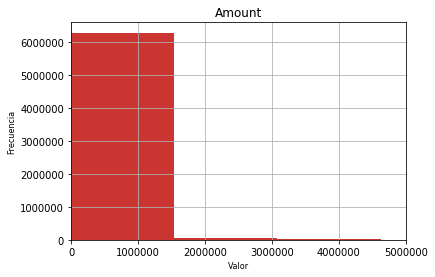

<Figure size 432x288 with 0 Axes>

In [10]:
plt.title('Amount')
plt.hist(des_analysis['amount'], bins = 60, color = '#CA3532')
plt.xlim(xmin=0, xmax = 0.5e+07)
plt.xlabel('Valor',fontsize=8)
plt.ylabel('Frecuencia',fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()
plt.clf()

Según el histograma, la mayor parte de las cantidades que se transfieren, son menores a 2.000.000 u.m. 
Para identificar cómo se distribuye esta variable, calculamos la tabla de frecuencias, categorizando la variable según el resultado del histograma:

In [11]:
# Calculamos los tramos de subdivisión:
bins = (0, 200000, 400000, 9.244552e+07)

# Categorizamos con la función cut
des_analysis['amount_category'] = pd.cut(des_analysis['amount'], bins, include_lowest=True)

In [12]:
#Calculamos las frecuencias absolutas y relativas de la variable:

#Sacamos los datos únicos del df:
lis = des_analysis["amount_category"].unique()
#Creamos el dataframe que contendrá las clases
dat = pd.DataFrame(lis, columns=["amount_category"])
#Observamos las clases que tenemos
dat

#Columna: frecuencias absolutas
#Obtenemos las frecuencias absolutas de cada clase
datafi = pd.crosstab(index=des_analysis["amount_category"], columns = "fi")
#Creamos una lista con los valores de las frecuencias
li = datafi.values

#Agregamos la columna al dataframe
dat["fi"] = li

# Calculamos el número de registros
n=des_analysis.shape[0]

#Columna: frecuencias relativas
datahi = 100 * datafi["fi"] / n
datahi = datahi.values
#Agregamos nueva columna de frecuentas relativas
dat["hi"] = datahi
#Observamos
dat

,amount_category,fi,hi
0,"(-0.001, 200000.0]",4689050,73.696842
1,"(200000.0, 400000.0]",1144175,17.982765
2,"(400000.0, 92445520.0]",529395,8.320393


El 73.69% de las transacciones tiene un importe igual o menor a 200.000 u.m., el 18% se han operado con un importe entre 200.000 y 400.000 u.m y unicamente el 8,3% de las transacciones se realizan por un importe superior a 400.000 u.m.

Según la bibliografía, se considera un **intento de transacción ilegal a aquella transacción cuya cantidad sea superior a 200.000 u.m**. En los próximos análisis, estudiaremos si aquellas cantidades que superan los límites legales están consideradas como transacciones ilegales en la variable *isFlaggedFraud*(Indicador de transacción ilegal): `isFlaggedFraud == 1`.  

Por otro lado, identificamos cuántos registros contienen la variable `amount == 0`

In [13]:
des_analysis.loc[des_analysis['amount'] == 0.0].shape[0]

16

Existen 16 registros que tienen la variable *amount* igual a cero. Comprobamos estos registros en el dataframe original `df`:

In [14]:
df.loc[df['amount'] == 0.0].head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1.0,0.0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1.0,0.0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1.0,0.0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1.0,0.0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1.0,0.0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1.0,0.0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1.0,0.0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1.0,0.0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1.0,0.0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1.0,0.0


A la vista de la tabla, comprobamos que estos 16 registros son considerados fraudulentos. Consideramos **no eliminar estos registros** ya que esta casuística es interesante a la hora de detectar transacciones fraudulentas. Además, las 16 transacciones pertenecen a la categoría *CASH_OUT*, el tipo de emisor es de tipo 'C' y el tipo de receptor también lo es ('C' = Customer).

* **Variable oldbalanceOrg**  
En primer lugar, construimos el histograma de frecuencias para la variable *oldbalanceOrg*: 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


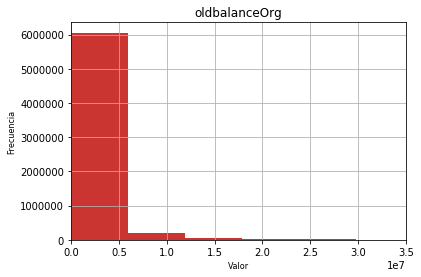

<Figure size 432x288 with 0 Axes>

In [15]:
plt.title('oldbalanceOrg')
plt.hist(des_analysis['oldbalanceOrg'], bins = 10, color = '#CA3532')
plt.xlim(xmin=0, xmax = 3.5e+07)
plt.xlabel('Valor',fontsize=8)
plt.ylabel('Frecuencia',fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()
plt.clf()

Según el histograma, *el saldo inicial antes de la transacción en la cuenta de origen* suele ser menor a 0.5e+7 u.m. 
Para identificar cómo se distribuye esta variable, calculamos la tabla de frecuencias, categorizando la variable en base al  resultado del histograma:

In [16]:
# Calculamos los tramos de subdivisión:
bins = (0, 200000, 400000, 6e+07)

# Categorizamos con la función cut
des_analysis['oldbalanceOrg_category'] = pd.cut(des_analysis['oldbalanceOrg'], bins, include_lowest=True)

In [17]:
#Calculamos las frecuencias absolutas y relativas de la variable:

#Sacamos los datos únicos del df:
lis = des_analysis["oldbalanceOrg_category"].unique()
#Creamos el dataframe que contendrá las clases
dat = pd.DataFrame(lis, columns=["oldbalanceOrg_category"])
#Observamos las clases que tenemos
dat

#Columna: frecuencias absolutas
#Obtenemos las frecuencias absolutas de cada clase
datafi = pd.crosstab(index=des_analysis["oldbalanceOrg_category"], columns = "fi")
#Creamos una lista con los valores de las frecuencias
li = datafi.values

#Agregamos la columna al dataframe
dat["fi"] = li

# Calculamos el número de registros
n=des_analysis.shape[0]

#Columna: frecuencias relativas
datahi = 100 * datafi["fi"] / n
datahi = datahi.values
#Agregamos nueva columna de frecuentas relativas
dat["hi"] = datahi
#Observamos
dat

,oldbalanceOrg_category,fi,hi
0,"(-0.001, 200000.0]",5096791,80.105224
1,"(400000.0, 60000000.0]",309661,4.866879
2,"(200000.0, 400000.0]",956168,15.027897


El 80.10% de las transacciones proceden de cuentas cuyo saldo inicial es igual o menor a 200.000u.m., el 15.03% de las cuentas origen tiene un saldo entre 200.000 y 400.000 u.m y unicamente el 4.86% de las cuentas origen tienen un saldo superior a 400.000 u.m.

En la fase de análisis bivariante, estudiaremos cómo se distribuye ésta variable con *isFlaggedFraud* (Indicador de transacción ilegal) para identificar si existe relación entre la cantidad de saldo existente en la cuenta origen previo a la transacción y la legalidad de la transacción realizada.

Adicionalmente, analizamos el volumen de transacciones que se realizan cuya cuenta origen tiene un saldo inicial de 0.0 u.m.

In [18]:
des_analysis.loc[des_analysis['oldbalanceOrg'] == 0.0].shape[0]

2102449

Existen 2.102.449 registros que tienen la variable *oldbalanceOrg* igual a cero. Comprobamos estos registros:

In [19]:
df.loc[df['oldbalanceOrg'] == 0.0].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
29,1,PAYMENT,9920.52,C764826684,0.0,0.0,M1940055334,0.0,0.00,0.0,0.0
30,1,PAYMENT,3448.92,C2103763750,0.0,0.0,M335107734,0.0,0.00,0.0,0.0
31,1,PAYMENT,4206.84,C215078753,0.0,0.0,M1757317128,0.0,0.00,0.0,0.0
32,1,PAYMENT,5885.56,C840514538,0.0,0.0,M1804441305,0.0,0.00,0.0,0.0
33,1,PAYMENT,5307.88,C1768242710,0.0,0.0,M1971783162,0.0,0.00,0.0,0.0
34,1,PAYMENT,5031.22,C247113419,0.0,0.0,M151442075,0.0,0.00,0.0,0.0
35,1,PAYMENT,24213.67,C1238616099,0.0,0.0,M70695990,0.0,0.00,0.0,0.0
44,1,PAYMENT,5086.48,C598357562,0.0,0.0,M1593224710,0.0,0.00,0.0,0.0
48,1,CASH_OUT,5346.89,C512549200,0.0,0.0,C248609774,652637.0,6453430.91,0.0,0.0
79,1,TRANSFER,77957.68,C207471778,0.0,0.0,C1761291320,94900.0,22233.65,0.0,0.0


Como se observa en la tabla, aparecen registros en los que la cuenta origen está a cero, pero la variable amount tiene un valor superior a cero. En la fase de análisis bivariante deberemos estudiar los siguiente análisis para determinar si estos registros son outliers:  
* En qué casos, la variable `amount > 0.0`, `oldbalanceOrg == 0.0`, `newbalanceOrig == 0.0`, `oldbalanceDest == 0.0`, `newbalanceDest == 0.0` y `isFraud == 0` (posibles outliers) y analizar el tipo de operación asociada a estos casos
* En qué casos, la variable `amount == 0.0` y `oldbalanceOrg == 0.0`
* En qué casos, la variable `amount == 0.0` y `oldbalanceOrg > 0.0`

* **Variable newbalanceOrig**  
Para analizar la variable *newbalanceOrig*, primero, construimos su histograma de frecuencias: 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


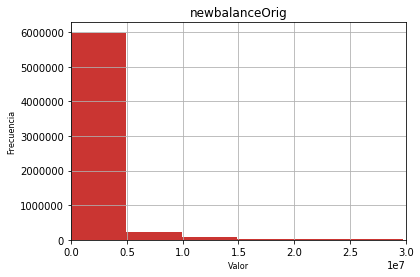

<Figure size 432x288 with 0 Axes>

In [20]:
plt.title('newbalanceOrig')
plt.hist(des_analysis['newbalanceOrig'], bins = 10, color = '#CA3532')
plt.xlim(xmin=0, xmax = 3e+07)
plt.xlabel('Valor',fontsize=8)
plt.ylabel('Frecuencia',fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()
plt.clf()

Según el histograma, la mayor parte de las cuentas origen, se quedan en saldos inferiores a 1.5e+7 una vez realizada la transacción. 
Para identificar cómo se distribuye esta variable, calculamos la tabla de frecuencias teniendo en cuenta el resultado del histograma, categorizando la variable:

In [21]:
# Calculamos los tramos de subdivisión:
bins = (0, 200000, 400000, 5e+07)

# Categorizamos con la función cut
des_analysis['newbalanceOrig_category'] = pd.cut(des_analysis['newbalanceOrig'], bins, include_lowest=True)

In [22]:
#Calculamos las frecuencias absolutas y relativas de la variable:

#Sacamos los datos únicos del df:
lis = des_analysis["newbalanceOrig_category"].unique()
#Creamos el dataframe que contendrá las clases
dat = pd.DataFrame(lis, columns=["newbalanceOrig_category"])
#Observamos las clases que tenemos
dat

#Columna: frecuencias absolutas
#Obtenemos las frecuencias absolutas de cada clase
datafi = pd.crosstab(index=des_analysis["newbalanceOrig_category"], columns = "fi")
#Creamos una lista con los valores de las frecuencias
li = datafi.values

#Agregamos la columna al dataframe
dat["fi"] = li

# Calculamos el número de registros
n=des_analysis.shape[0]

#Columna: frecuencias relativas
datahi = 100 * datafi["fi"] / n
datahi = datahi.values
#Agregamos nueva columna de frecuentas relativas
dat["hi"] = datahi
#Observamos
dat

,newbalanceOrig_category,fi,hi
0,"(-0.001, 200000.0]",4961775,77.983205
1,"(400000.0, 50000000.0]",398502,6.263175
2,"(200000.0, 400000.0]",1002343,15.753620


El 77.98% de las transacciones proceden de cuentas cuyo saldo después de la transacción es igual o menor a 200.000 u.m., el 15.75% de las cuentas origen tiene un saldo posterior a la transacción entre 200.000 y 400.000 u.m y unicamente el 6.26% de las cuentas origen tienen un saldo superior a 400.000 u.m. una vez realizada la transacción

Adicionalmente, analizamos el volumen de transacciones que se realizan cuya cuenta origen tiene un saldo después de la transacción de 0.0 u.m.

In [23]:
des_analysis.loc[des_analysis['newbalanceOrig'] == 0.0].shape[0]

3609566

Encontramos 3.609.566 registros en los que la cuenta origen se queda a 0, una vez realizada la transacción. Comprobamos el dataframe:

In [24]:
df.loc[df['newbalanceOrig'] == 0.0].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.0,0.0,M1176932104,0.0,0.00,0.0,0.0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.0,C997608398,10845.0,157982.12,0.0,0.0
13,1,PAYMENT,11633.76,C1716932897,10127.0,0.0,M801569151,0.0,0.00,0.0,0.0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0.0,0.0
16,1,PAYMENT,1563.82,C761750706,450.0,0.0,M1731217984,0.0,0.00,0.0,0.0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0.0,0.0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0.0,0.0
25,1,PAYMENT,6061.13,C1043358826,443.0,0.0,M1558079303,0.0,0.00,0.0,0.0


En la fase de análisis bivariante vamos a centrarnos en analizar los casos para los que la variable `oldbalanceOrg > 0.0` y `newbalanceOrig == 0.0 `. 

* **Variable oldbalanceDest**  
Para analizar la variable *oldbalanceDest*, primero, construimos su histograma de frecuencias:

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


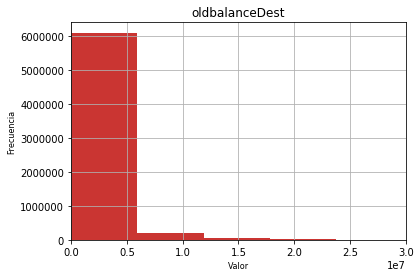

<Figure size 432x288 with 0 Axes>

In [25]:
plt.title('oldbalanceDest')
plt.hist(des_analysis['oldbalanceDest'], bins = 60, color = '#CA3532')
plt.xlim(xmin=0, xmax = 0.3e+08)
plt.xlabel('Valor',fontsize=8)
plt.ylabel('Frecuencia',fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()
plt.clf()

Según el histograma, el saldo inicial en la cuenta de origen antes de recibir la transacción suele ser 0.5e+7 u.m. 
Para identificar cómo se distribuye esta variable, calculamos la tabla de frecuencias teniendo en cuenta el resultado del histograma, categorizando la variable:

In [26]:
# Calculamos los tramos de subdivisión:
bins = (0, 200000, 400000, 3.560159e+08)

# Categorizamos con la función cut
des_analysis['oldbalanceDest_category'] = pd.cut(des_analysis['oldbalanceDest'], bins, include_lowest=True)

In [27]:
#Calculamos las frecuencias absolutas y relativas de la variable:

#Sacamos los datos únicos del df:
lis = des_analysis["oldbalanceDest_category"].unique()
#Creamos el dataframe que contendrá las clases
dat = pd.DataFrame(lis, columns=["oldbalanceDest_category"])
#Observamos las clases que tenemos
dat

#Columna: frecuencias absolutas
#Obtenemos las frecuencias absolutas de cada clase
datafi = pd.crosstab(index=des_analysis["oldbalanceDest_category"], columns = "fi")
#Creamos una lista con los valores de las frecuencias
li = datafi.values

#Agregamos la columna al dataframe
dat["fi"] = li

# Calculamos el número de registros
n=des_analysis.shape[0]

#Columna: frecuencias relativas
datahi = 100 * datafi["fi"] / n
datahi = datahi.values
#Agregamos nueva columna de frecuentas relativas
dat["hi"] = datahi
#Observamos
dat

,oldbalanceDest_category,fi,hi
0,"(-0.001, 200000.0]",3401151,53.455196
1,"(200000.0, 400000.0]",553124,8.693337
2,"(400000.0, 356015900.0]",2408345,37.851467


El 53.45% de las cuentas destino, tienen un saldo antes de la transferencia inferior a 200.000 u.m., el 8,69% de las cuentas destino tiene un saldo anterior a la transacción entre 200.000 y 400.000 u.m y el 37.85% de las cuentas destino tienen un saldo superior a 400.000 u.m. antes de que se realice la transacción.

Adicionalmente, analizamos aquellas cuentas destino, cuyo saldo inicial, previo a la transacción es de 0.0 u.m.

In [28]:
des_analysis.loc[des_analysis['oldbalanceDest'] == 0.0].shape[0]

2704388

Encontramos 2.704.388 registros en los que la cuenta destino tiene un salgo de 0 antes de recibir la transacción. Comprobamos el dataframe:

In [29]:
df.loc[df['oldbalanceDest'] == 0.0].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.0,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.0,0.0,0.0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.0,0.0,0.0
11,1,PAYMENT,3099.97,C249177573,20771.00,17671.03,M2096539129,0.0,0.0,0.0,0.0
12,1,PAYMENT,2560.74,C1648232591,5070.00,2509.26,M972865270,0.0,0.0,0.0,0.0


Como se observa, cuando la cuenta de destino pertenece a un Comerciante (nameDest = 'M'), el saldo en su cuenta no viene informado, como no podemos comprobar si la transferencia se ha realizado o no, damos por válidas estas transacciones. Igualmente, en el análisis bivariante, analizaremos esta casuísitica. 
Por otro lado, analizaremos la existencia de casos en los que la variable `amount == 0.0` y `oldbalanceDest < newbalanceDest`.

* **Variable newbalanceDest**  
Para analizar la variable *newbalanceDest*, primero, construimos su histograma de frecuencias:

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


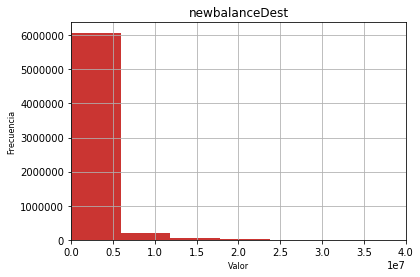

<Figure size 432x288 with 0 Axes>

In [30]:
plt.title('newbalanceDest')
plt.hist(des_analysis['newbalanceDest'], bins = 60, color = '#CA3532')
plt.xlim(xmin=0, xmax = 0.4e+08)
plt.xlabel('Valor',fontsize=8)
plt.ylabel('Frecuencia',fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()
plt.clf()

Según el histograma, el saldo en la cuenta destino una vez recibida la transacción suele ser menor a 1e+7 u.m. 
Para identificar cómo se distribuye esta variable, calculamos la tabla de frecuencias teniendo en cuenta el resultado del histograma, categorizando la variable:

In [31]:
# Calculamos los tramos de subdivisión:
bins = (0, 200000, 400000, 3.561793e+08)

# Categorizamos con la función cut
des_analysis['newbalanceDest_category'] = pd.cut(des_analysis['newbalanceDest'], bins, include_lowest=True)

In [32]:
#Calculamos las frecuencias absolutas y relativas de la variable:

#Sacamos los datos únicos del df:
lis = des_analysis["newbalanceDest_category"].unique()
#Creamos el dataframe que contendrá las clases
dat = pd.DataFrame(lis, columns=["newbalanceDest_category"])
#Observamos las clases que tenemos
dat

#Columna: frecuencias absolutas
#Obtenemos las frecuencias absolutas de cada clase
datafi = pd.crosstab(index=des_analysis["newbalanceDest_category"], columns = "fi")
#Creamos una lista con los valores de las frecuencias
li = datafi.values

#Agregamos la columna al dataframe
dat["fi"] = li

# Calculamos el número de registros
n=des_analysis.shape[0]

#Columna: frecuencias relativas
datahi = 100 * datafi["fi"] / n
datahi = datahi.values
#Agregamos nueva columna de frecuentas relativas
dat["hi"] = datahi
#Observamos
dat

,newbalanceDest_category,fi,hi
0,"(-0.001, 200000.0]",3132204,49.228211
1,"(400000.0, 356179300.0]",578314,9.089243
2,"(200000.0, 400000.0]",2652102,41.682546


El 49,23% de las cuentas destino, tienen un saldo posterior a la transferencia inferior a 200.000 u.m., el 41.68% de las cuentas destino tiene un saldo posterior a la transacción entre 200.000 y 400.000 u.m y el 9.09% de las cuentas destino tienen un saldo superior a 400.000 u.m. después de que se realice la transacción.

Adicionalmente, analizamos aquellas cuentas destino, cuyo saldo posterior a la transacción es de 0.0 u.m.

In [33]:
des_analysis.loc[des_analysis['newbalanceDest'] == 0.0].shape[0]

2439433

Encontramos 2.439.433 registros en los que la cuenta destino tiene un salgo de 0 después de recibir la transacción. Comprobamos el dataframe:

In [34]:
df.loc[df['newbalanceDest'] == 0.0].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.0,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.0,0.0,0.0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.0,0.0,0.0
11,1,PAYMENT,3099.97,C249177573,20771.00,17671.03,M2096539129,0.0,0.0,0.0,0.0


Como se observa, cuando la cuenta destino pertenece a un comercio (NameDest = 'M'), el balance de sus cuentas no viene informado. Sin embargo, cuando la cuenta destino pertenece a un cliente particular, sí debería estar informado, por ello, analizaremos aquellos casos en los que `amount > 0.0` `newbalanceDest == 0.0` y `NameDest = 'C'` y checkearemos si esas transaciones están marcadas como fraudulentas.

**Análisis de las variables categóricas**  
En este análisis vamos a construir gráficos de barras y tablas de frecuencias donde se evalúe la distribución de cada variable categórica.

* **Variable type**  
Para analizar la variable *type*, construimos su diagrama de barras:

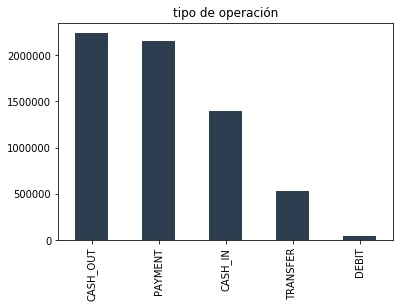

In [35]:
# Gráfico de barras:
plot = df['type'].value_counts().plot(kind='bar',
                                            title='tipo de operación',
                                     color = '#2C3E50')

Si nos enfocarnos en la proporción relativa de las transacciones de cada una de las tipologías de operación, simplemente podemos sustituir a los recuentos con porcentajes y utilizar un gráfico de barras de frecuencias relativas.

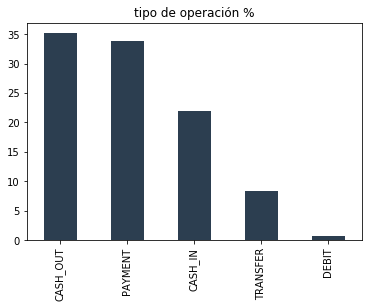

In [36]:
# gráfico de barras de frecuencias relativas.
plot = (100 * df['type'].value_counts() / len(df['type'])).plot(
kind='bar', title='tipo de operación %', color = '#2C3E50')

El 35% de las transacciones son realizadas vía CASH OUT, es decir, la retirada de dinero en efectivo de la cuenta, el 33% corresponden a pagos utilizando el servicio de dinero móvil, el 22% son pagos en efectivo, el 8% son transferencias entre cuentas y el 2% son envíos de dinero del servicio de dinero móvil a una cuenta bancaria.

* **Variable isFraud**  
Para analizar la variable *isFraud*, primero, construimos su diagrama de barras:

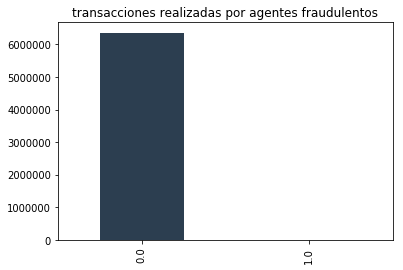

In [37]:
# Gráfico de barras:
plot = df['isFraud'].value_counts().plot(kind='bar',
                                            title='transacciones realizadas por agentes fraudulentos', color = '#2C3E50')

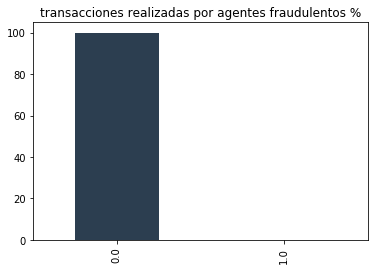

In [38]:
# gráfico de barras de frecuencias relativas.
plot = (100 * df['isFraud'].value_counts() / len(df['isFraud'])).plot(
kind='bar', title='transacciones realizadas por agentes fraudulentos %', color = '#2C3E50')

### Análisis bivariante y multivariante  
Con el análisis bivariable describimos y evaluamos la relación entre dos variables o el comportamiento de una variable en función de otra. A través del análisis multivariable estudiamos tres o más variables de modo simultáneo y tratamos de determinar la relación entre ellas.  
En esta fase de estudio, vamos a llevar a cabo los análisis propuestos en el análisis univariante para obtener una visión más completa de los datos.

Para llevar a cabo el estudio, y puesto que vamos a comparar variables entre sí, incluímos en el dataframe `des_analysis`, las variables *type*, *isFraud*, *isFlaggedFraud*:

In [39]:
des_analysis[['type','isFraud', 'isFlaggedFraud', 'nameDest', 'nameOrig']] = df[['type','isFraud', 'isFlaggedFraud', 'nameDest', 'nameOrig']]

des_analysis.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,amount_category,oldbalanceOrg_category,newbalanceOrig_category,oldbalanceDest_category,newbalanceDest_category,type,isFraud,isFlaggedFraud,nameDest,nameOrig
0,9839.64,170136.0,160296.36,0.0,0.0,"(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]",PAYMENT,0.0,0.0,M1979787155,C1231006815
1,1864.28,21249.0,19384.72,0.0,0.0,"(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]",PAYMENT,0.0,0.0,M2044282225,C1666544295
2,181.00,181.0,0.00,0.0,0.0,"(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]",TRANSFER,1.0,0.0,C553264065,C1305486145
3,181.00,181.0,0.00,21182.0,0.0,"(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]",CASH_OUT,1.0,0.0,C38997010,C840083671
4,11668.14,41554.0,29885.86,0.0,0.0,"(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]","(-0.001, 200000.0]",PAYMENT,0.0,0.0,M1230701703,C2048537720


**Análisis de las variables numéricas continuas**  
En este análisis vamos a construir matrices de contingencia donde se evalúe la relación de la variable dependiente con las variables predictoras de tipo continuo:

* **Variable amount**  

Para la variable *amount* se ha identificado que el 26.31% de las transacciónes tienen un importe superior a 200.000u.m. Según la bibliografía, se considera un intento de transacción ilegal a aquella transacción cuya cantidad es superior a 200.000 u.m. por lo que ahora, vamos a estudiar que valores toma la variable *isFlaggedFraud* y comprobaremos si están identficados cómo transacciones ilegales o no: 

In [40]:
# Tabla de contingencia:
pd.crosstab(index=des_analysis['amount_category'],columns=des_analysis['isFlaggedFraud'], margins=True)

isFlaggedFraud,0.0,1.0,All
amount_category,,,
"(-0.001, 200000.0]",4689050,0,4689050
"(200000.0, 400000.0]",1144173,2,1144175
"(400000.0, 92445520.0]",529381,14,529395
All,6362604,16,6362620


Según la tabla de contingencia, unicamente 16 transacciones realizadas por una cantidad superior a 200.000 u.m. han sido consideradas ilegales. 
Comprobamos qué características tienen estas 16 transacciones consideradas ilegales para identificar el motivo por el que han sido consideradas ilegales frente al 1.6M de transacciones que no han sido consideradas ilegales y cuya cantidad supera los 200.000 u.m.

In [41]:
df.loc[(df['amount'] >= 200000) & (df['isFlaggedFraud'] == 1)].head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1.0,1.0
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1.0,1.0
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1.0,1.0
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1.0,1.0
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1.0,1.0
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1.0,1.0
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1.0,1.0
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1.0,1.0
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1.0,1.0
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1.0,1.0


Identificamos las características de estas transferencias:
* La cantidad a transferir es superior a los 200.000 u.m.
* Las transferencias se realizan entre personas físicas (nameOrig  y nameDest empiezan por la letra 'C').
* Todas las transacciones son de tipo TRANSFER, *envíos  de dinero entre usuarios del servicio a través de la plataforma de dinero móvil*.
* Las transferencias no se han llegado a realizar ya que tanto la cuenta del emisor como la del receptor no han variado.
* La variable *isFraud* es igual a 1 por lo que se consideran que estas transacciones han sido realizadas por agentes fraudulentos.

Además, en 10 de las 16 transacciones (el 62.5% de las veces) la cantidad a transferir es la misma que la que tiene el emisor en origen.  

**CONCLUSIÓN**: Puesto que el campo isFlaggedFraud no está considerando todas las transacciones que superan los 200.000u.m., vamos a generar una nueva variable que considere todas las transacciones que superan esta cantidad.

Por comprobamos si en el dataframe, hay más casos de transferencias que cumplen las mismas casuísticas, pero en cambio, las transacciones no se han considerado ilegales:

In [42]:
df.loc[(df['amount'] >= 200000) & 
       (df['type'] == 'TRANSFER') &
       (df['oldbalanceOrg'] == df['newbalanceOrig']) &
       (df['oldbalanceDest'] == df['newbalanceDest'])].shape[0]

19

Encontramos 3 casos más, que tienen las mismas características, pero, en cambio, no están consideradas transacciones ilegales. Comprobamos estos registros:

In [43]:
df.loc[(df['amount'] >= 200000) & 
       (df['type'] == 'TRANSFER') &
       (df['oldbalanceOrg'] == df['newbalanceOrig']) &
       (df['oldbalanceDest'] == df['newbalanceDest'])].head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1248,1,TRANSFER,271161.74,C1658487789,0.00,0.00,C1219161283,0.0,0.0,0.0,0.0
160646,12,TRANSFER,342317.15,C2070529657,0.00,0.00,C621118463,0.0,0.0,0.0,0.0
282796,15,TRANSFER,421255.41,C1734485985,0.00,0.00,C981307359,0.0,0.0,0.0,0.0
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1.0,1.0
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1.0,1.0
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1.0,1.0
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1.0,1.0
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1.0,1.0
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1.0,1.0
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1.0,1.0


En las filas *1.248*, *160.646* y *282.796* se han registrado transacciones que no se han llegado a efectuar puesto que las cuentas origen y destino no se han visto modificadas, el saldo inicial de las cuentas origen es cero. Estos casos se analizarán en próximos pasos para ver cómo considerarlos (posibles outliers).

**CONCLUSIÓN**: Analizar para las filas *1.248*, *160.646*, *282.796* la casuística siguiente: `amount > 0.0`, `oldbalanceOrg == 0.0`, `newbalanceOrig == 0.0`, `oldbalanceDest == 0.0` y `newbalanceDest == 0.0`  (posibles outliers) y analizar el tipo de operación asociada a estos casos  y el valor de la variable *isFraud*.

Por último, identificamos si existe alguna relación entre el tipo de operación realizada y la cantidad de dinero a transferir:

In [44]:
pd.crosstab(index=des_analysis['type'], columns=des_analysis['amount_category'], normalize='index')

amount_category,"(-0.001, 200000.0]","(200000.0, 400000.0]","(400000.0, 92445520.0]"
type,,,
CASH_IN,0.659920,0.283391,0.056688
CASH_OUT,0.647571,0.286839,0.065590
DEBIT,0.999348,0.000531,0.000121
PAYMENT,0.999997,0.000003,0.000000
TRANSFER,0.232308,0.198533,0.569159


**CONCLUSIÓN**: El 76% de las transferencias se realizan por un importe superior a 200.000.u.m, el 28% de los pagos en efectivo y la retirada en efectivo se realiza por un importe superior a 200.000 u.m.

* **Variable oldbalanceOrg**  

En el análisis univariante, se ha planteado realizar los siguientes análisis para la variable *olbalanceOrg*:
* Estudiar cómo se distribuye la variable *oldbalanceOrg* con *isFlaggedFraud*. Puesto que en el paso anterior hemos determinado que la variable *isFlaggedFraud* no está bien calculada, no vamos a realizar el análisis.
* Estudiar aquellos casos para los que la variable `amount > 0.0`, `oldbalanceOrg == 0.0`, `newbalanceOrig == 0.0`, `oldbalanceDest == 0.0`, `newbalanceDest == 0.0` y `isFraud == 0` (posibles outliers) y analizar el tipo de operación asociada a estos casos
* Estudiar aquellos casos para los que la variable `amount == 0.0` y `oldbalanceOrg == 0.0`
* Estudiar aquellos casos para los que la variable `amount == 0.0` y `oldbalanceOrg > 0.0`

In [45]:
# Tabla de contingencia:
pd.crosstab(index=((des_analysis['oldbalanceOrg'] == 0) &
                  (des_analysis['newbalanceOrig'] == 0) &
                  (des_analysis['oldbalanceDest'] == 0) &
                  (des_analysis['newbalanceDest'] == 0) &
                  (des_analysis['amount'] > 0)),columns=des_analysis['isFraud'], margins=True)

isFraud,0.0,1.0,All
row_0,,,
False,5580138,8213,5588351
True,774269,0,774269
All,6354407,8213,6362620


A continuación, vamos a analizar que tipo de operación se ha realizado según esta casuística:

In [46]:
# Tabla de contingencia: Merchant
pd.crosstab(index=((des_analysis['oldbalanceOrg'] == 0) &
                  (des_analysis['newbalanceOrig'] == 0) &
                  (des_analysis['oldbalanceDest'] == 0) &
                  (des_analysis['newbalanceDest'] == 0) &
                  (df["nameDest"].str.slice(stop=1) == 'M') &
                  (des_analysis['amount'] > 0) & (des_analysis['isFraud'] == 0)),columns=des_analysis['type'], margins=True)

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,All
row_0,,,,,,
False,1399284,2237481,41432,1377250,532904,5588351
True,0,19,0,774245,5,774269
All,1399284,2237500,41432,2151495,532909,6362620


In [46]:
# Tabla de contingencia: Costumber
pd.crosstab(index=((des_analysis['oldbalanceOrg'] == 0) &
                  (des_analysis['newbalanceOrig'] == 0) &
                  (des_analysis['oldbalanceDest'] == 0) &
                  (des_analysis['newbalanceDest'] == 0) &
                  (df["nameDest"].str.slice(stop=1) == 'C') &
                  (des_analysis['amount'] > 0) & (des_analysis['isFraud'] == 0)),columns=des_analysis['type'], margins=True)

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,All
row_0,,,,,,
False,1399284,2237481,41432,1377250,532904,5588351
True,0,19,0,774245,5,774269
All,1399284,2237500,41432,2151495,532909,6362620


**CONCLUSIÓN**: Existen 774.269 que tienen los balances a cero pero la variable amount es superior a cero y no son considerados fraudulentos. Según la bibliografía, las categorías PAYMENT, TRANSFER y CASH_OUT implican variación en los balances de las cuentas origen y destino. Puesto que estos casos no cumplen con lo definido, se considerarán outliers y se eliminaran del dataframe ya que solo generan ruido.

* En qué casos, la variable `amount == 0.0` y `oldbalanceOrg == 0.0`

In [47]:
# Tabla de contingencia:
pd.crosstab(index=((des_analysis['amount'] == 0) & (des_analysis['oldbalanceOrg'] == 0)),columns=des_analysis['isFraud'], margins=True)

isFraud,0.0,1.0,All
row_0,,,
False,6354407,8197,6362604
True,0,16,16
All,6354407,8213,6362620


**CONCLUSIÓN**: Existen 16 registros para los que la variable amount es igual a cero y la varible oldbalacenOrg es igual a cero, lo que supone que no se ha debido de realizar la transferencia puesto que la cantidad a transferir es 0. Entendemos que al no haber variación en los balances puesto que la cantidad transferida es cero, los criterios de negocio consideran la transacción fraudulenta y por ello no conviene eliminarlos del dataframe.

* En qué casos, la variable `amount == 0.0` y `oldbalanceOrg > 0.0`

In [48]:
# Tabla de contingencia:
pd.crosstab(index=((des_analysis['amount'] == 0) & (des_analysis['oldbalanceOrg'] > 0)),columns=des_analysis['isFraud'], margins=True)

isFraud,0.0,1.0,All
row_0,,,
False,6354407,8213,6362620
All,6354407,8213,6362620


**CONCLUSIÓN**: No existen registros para los que la cantidad a tranferir sea cero y el balance en la cuenta origen sea positivo.

* **Variable newbalanceOrig**  

En el análisis univariante hemos determinado que el 77.98% de las transacciones proceden de cuentas cuyo saldo después de la transacción es igual o menor a 200.000 u.m., el 15.75% de las cuentas origen tiene un saldo posterior a la transacción entre 200.000 y 400.000 u.m y unicamente el 6.26% de las cuentas origen tienen un saldo superior a 400.000 u.m. una vez realizada la transacción.  
En esta fase vamos a llevar a cabo el siguiente análisis: 
* En qué casos, la variable `oldbalanceOrg > 0.0` y `newbalanceOrig == 0.0`

In [49]:
df.loc[(df['oldbalanceOrg'] > 0) & 
       (df['newbalanceOrig'] == 0)].shape[0]

1520581

Existen 1.520.581 casos para los que el saldo en la cuenta origen es superior a cero y una vez realizada la transferencia, el saldo en la cuenta origen es cero. Esta situación se puede dar bajo las siguientes casuísticas:
* Cuando la cantidad transferida es igual al saldo en la cuenta origen
* Cuando la cantidad transferida es superior al saldo en la cuenta origen

En primer lugar, analizamos los casos cuando la cantidad transferida es igual al saldo en la cuenta origen:

In [50]:
df.loc[(df['oldbalanceOrg'] > 0) & 
       (df['newbalanceOrig'] == 0) &
       (df['amount'] == df['oldbalanceOrg'])].shape[0]

8008

In [51]:
# Tabla de contingencia:
pd.crosstab(index=((des_analysis['oldbalanceOrg'] > 0) & 
                   (des_analysis['newbalanceOrig'] == 0) &
                   (des_analysis['amount'] == des_analysis['oldbalanceOrg'])),
            columns=des_analysis['isFraud'], 
            margins=True)

isFraud,0.0,1.0,All
row_0,,,
False,6354407,205,6354612
True,0,8008,8008
All,6354407,8213,6362620


**CONCLUSIÓN**: De 1.5M de registros, 8.008 (0.53%) pertenecen a transacciones en las que cantidad enviada corresponde con el saldo de la cuenta origen. Entendemos que según criterios de negocio, esta casuísitica es considerada fraudulenta.

A continuación, analizamos la segunda casuística: la cantidad transferida es superior al saldo que hay en la cuenta origen antes de realizar la transacción.

In [52]:
df.loc[(df['oldbalanceOrg'] > 0) & 
       (df['newbalanceOrig'] == 0) &
       (df['amount'] > df['oldbalanceOrg'])].shape[0]

1512573

In [53]:
# Tabla de contingencia:
pd.crosstab(index=((des_analysis['oldbalanceOrg'] > 0) & 
                   (des_analysis['newbalanceOrig'] == 0) &
                   (des_analysis['amount'] > des_analysis['oldbalanceOrg'])),
            columns=des_analysis['isFraud'], 
            margins=True)

isFraud,0.0,1.0,All
row_0,,,
False,4841838,8209,4850047
True,1512569,4,1512573
All,6354407,8213,6362620


En este caso, nos interesa conocer qué tipo de operación se ha realizado, Para ello, obtenemos las tablas de contingencia:

In [54]:
# Tabla de contingencia:
pd.crosstab(index=((des_analysis['oldbalanceOrg'] > 0) & 
                   (des_analysis['newbalanceOrig'] == 0) &
                   (des_analysis['amount'] > des_analysis['oldbalanceOrg'])),
            columns=des_analysis['type'], 
            margins=True)

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,All
row_0,,,,,,
False,1399284,1282163,35804,1824616,308180,4850047
True,0,955337,5628,326879,224729,1512573
All,1399284,2237500,41432,2151495,532909,6362620


In [55]:
# Tabla de contingencia para transacciones no fraudulentas:
pd.crosstab(index=((des_analysis['oldbalanceOrg'] > 0) & 
                   (des_analysis['newbalanceOrig'] == 0) &
                   (des_analysis['amount'] > des_analysis['oldbalanceOrg']) & (des_analysis['isFraud'] == 0)),
            columns=des_analysis['type'], 
            margins=True)

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,All
row_0,,,,,,
False,1399284,1282166,35804,1824616,308181,4850051
True,0,955334,5628,326879,224728,1512569
All,1399284,2237500,41432,2151495,532909,6362620


Comprobamos los registros que se han considerado fraudulentos:

In [56]:
df.loc[(df['oldbalanceOrg'] > 0) & 
                 (df['newbalanceOrig'] == 0) & 
                 (df['amount'] > df['oldbalanceOrg']) & 
                 (df['isFraud'] == 1)].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1911,1,CASH_OUT,132842.64,C13692003,4499.08,0.0,C297927961,0.00,132842.64,1.0,0.0
217978,13,TRANSFER,123194.95,C2143112877,79466.45,0.0,C1755380031,535933.16,263908.84,1.0,0.0
408955,18,CASH_OUT,314251.58,C1462280812,75956.47,0.0,C90486891,7962205.25,8276456.84,1.0,0.0
559979,22,CASH_OUT,89571.46,C1022920965,4505.60,0.0,C1460548505,1929428.01,2018999.47,1.0,0.0


Comprobamos los registros que no se han considerado fraudulentos:

In [57]:
df.loc[(df['oldbalanceOrg'] > 0) & 
                 (df['newbalanceOrig'] == 0) & 
                 (df['amount'] > df['oldbalanceOrg']) & 
                 (df['isFraud'] == 0)].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
8,1,PAYMENT,4024.36,C1265012928,2671.0,0.0,M1176932104,0.0,0.00,0.0,0.0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.0,C997608398,10845.0,157982.12,0.0,0.0
13,1,PAYMENT,11633.76,C1716932897,10127.0,0.0,M801569151,0.0,0.00,0.0,0.0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0.0,0.0
16,1,PAYMENT,1563.82,C761750706,450.0,0.0,M1731217984,0.0,0.00,0.0,0.0


**CONCLUSIÓN**: 1.512.573 registros en los que la cantidad enviada es mayor al saldo existente en la cuenta origen, de los cuáles, unicamente 4 han sido considerados fraudulentos. Puesto que la bibliografía no aporta información sobre esta casuísitca, no somos capaces de determinar cuál es el motivo de considerar unos registros como fraudulentos y otros no. Guiándonos por la experiencia, al haber una tan clara mayoría de que está casuística se considera no fraude, entendemos que los 4 registros están mal categorizados como fraudulentos. 

* **Variable oldbalanceDest**  

En primer lugar comprobamos que **el saldo de las cuentas de los comerciantes no viene informado**:

In [58]:
des_analysis['ind_merchant'] = np.where(des_analysis["nameDest"].str.slice(stop=1) == 'C', 0, 1)

des_analysis.groupby(['ind_merchant'])['oldbalanceDest'].sum()

ind_merchant
0    7.003346e+12
1    0.000000e+00
Name: oldbalanceDest, dtype: float64

In [59]:
des_analysis.groupby(['ind_merchant'])['newbalanceDest'].sum()

ind_merchant
0    7.794187e+12
1    0.000000e+00
Name: newbalanceDest, dtype: float64

Por otro lado,vamos a estudiar la existencia de casos en los que la variable `amount == 0.0` y `oldbalanceDest < newbalanceDest`, es decir, aparentemente no se ha realizado una transacción pero el balance en la cuenta destino sí ha variado:

In [60]:
df.loc[(df['amount'] == 0.0) & 
       (df['oldbalanceDest'] < df['newbalanceDest'])].shape[0]

0

**CONCLUSIÓN**: No existen casos en los que para una cantidad emitida de 0.0 u.m. el saldo en la cuenta destino se incremente.

* **Variable newbalanceDest** 

Cuando la cuenta destino pertenece a un comercio (NameDest = 'M'), el balance de sus cuentas no viene informado. Sin embargo, cuando la cuenta destino pertenece a un cliente particular, sí debería estar informado, por ello, analizaremos aquellos casos en los que `amount > 0.0` `newbalanceDest == 0.0` y `NameDest = 'C'` y checkearemos si esas transaciones están marcadas como fraudulentas.

In [61]:
df.loc[(df['amount'] > 0.0) & 
       (df['newbalanceDest'] == 0.0) &
       (df["nameDest"].str.slice(stop=1) == 'C')].shape[0]

287932

Existen 287.932 registros en los que se ha realizado la transacción entre particulares pero el saldo en la cuenta destino es cero. Comprobamos los casos:

In [62]:
df.loc[(df['amount'] > 0.0) & 
       (df['newbalanceDest'] == 0.0) &
       (df["nameDest"].str.slice(stop=1) == 'C')].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1.0,0.0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.0,0.0,0.0,0.0
22,1,DEBIT,1065.41,C1959239586,1817.00,751.59,C515132998,10330.0,0.0,0.0,0.0
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,C2001112025,25742.0,0.0,0.0,0.0


Generamos la tabla de contingencia para verificar qué casos son fraudulentos y cuáles no:

In [63]:
# Tabla de contingencia para transacciones no fraudulentas:
pd.crosstab(index=((df['amount'] > 0.0) &
                   (df['newbalanceDest'] == 0.0) &
                   (df["nameDest"].str.slice(stop=1) == 'C')),
            columns=des_analysis['isFraud'], 
            margins=True)

isFraud,0.0,1.0,All
row_0,,,
False,6070560,4128,6074688
True,283847,4085,287932
All,6354407,8213,6362620


In [64]:
# Tabla de contingencia para transacciones no fraudulentas:
pd.crosstab(index=((df['amount'] > 0.0) &
                   (df['amount'] == df['oldbalanceOrg']) &
                   (df['newbalanceDest'] == 0.0) &
                   (df["nameDest"].str.slice(stop=1) == 'C')),
            columns=des_analysis['isFraud'], 
            margins=True)

isFraud,0.0,1.0,All
row_0,,,
False,6354407,4276,6358683
True,0,3937,3937
All,6354407,8213,6362620


**CONCLUSIÓN**: cuando la cantidad enviada es igual al saldo en la cuenta origen,las reglas con las que se contruyó el dataset, sí detectan esos movimientos como fraude, en cambio, cuando el amount es mayor que lo que hay en la cuenta, no se está considerando fraude. Más adelante, tomaremos una decisión sobre estas casuísticas.

**Análisis de las variables categóricas**  
En este análisis vamos a construir matrices de contingencia donde se evalúe la relación de la variable dependiente con las variables predictoras de tipo categórico:

* **Relación entre *type* y la variable target *isFraud*** 

In [65]:
pd.crosstab(index=df['type'],columns=df['isFraud'], margins=True)

isFraud,0.0,1.0,All
type,,,
CASH_IN,1399284,0,1399284
CASH_OUT,2233384,4116,2237500
DEBIT,41432,0,41432
PAYMENT,2151495,0,2151495
TRANSFER,528812,4097,532909
All,6354407,8213,6362620


Como resultado obtenemos que, solo en 2 tipos aparecen transacciones realizadas por agentes fraudulentos, eso quiere decir que a priori, los agentes fraudulentos solo realizan retiradas de dinero (CASH-OUT) y envíos de dinero a otros usuarios del servicio móvil (TRANSFER).

* **Relación entre *isflaggedFraud* y la variable target *isFraud***  

La variable *isFlaggedFraud* es un indicador de transacción ilegal, mientras que la variable *isFraud* es un indicador de que la transacción ha sido realizada por un agente fraudulento. Observamos la relación entre ambas variables:

In [66]:
pd.crosstab(index=df['isFlaggedFraud'],columns=df['isFraud'], margins=True)

isFraud,0.0,1.0,All
isFlaggedFraud,,,
0.0,6354407,8197,6362604
1.0,0,16,16
All,6354407,8213,6362620


A la vista de la tabla, observamosque unicamente de las 8.213 transacciones realizadas por agentes fraudulentos, 16 son reconocidas como fraudulentas.

* **Relación entre orígen *nameOrig* y destino *nameDest***  

En este análisis vamos a estudiar el volumen de transacciones que han sido emitidas/recibidas y qué usuarios emiten transacciones.  

Primero, analizamos el volumen de usuarios según el número de transacciones que emiten en el período de estudio:

In [67]:
orig = df[['nameOrig','amount']].groupby(['nameOrig']).count()

print("Número de usuarios que han emitido 1 transacción en el mes:", sum(orig['amount'] == 1))
print("Número de usuarios que han emitido  2 transacciones en el mes:", sum(orig['amount'] == 2))
print("Número de usuarios que han emitido más de de 2 transacciones:", sum(orig['amount'] > 2))

Número de usuarios que han emitido 1 transacción en el mes: 6344009
Número de usuarios que han emitido  2 transacciones en el mes: 9283
Número de usuarios que han emitido más de de 2 transacciones: 15


Hacemos lo mismo para los usuarios que reciben transacciones:

In [68]:
dest = df[['nameDest','amount']].groupby(['nameDest']).count()
print("Número de usuarios que han recibido 1 transacción en el mes:", sum(dest['amount'] == 1))
print("Número de usuarios que han recibido  2 transacciones en el mes:", sum(dest['amount'] == 2))
print("Número de usuarios que han recibido más de de 2 transacciones:", sum(dest['amount'] > 2))

Número de usuarios que han recibido 1 transacción en el mes: 2262704
Número de usuarios que han recibido  2 transacciones en el mes: 77054
Número de usuarios que han recibido más de de 2 transacciones: 382604


En el df encontramos diferentes tipos de usuarios:
* Usuarios tipo C - usuarios particulares
* Usuarios tipo M - usuarios comerciantes

Comprobamos cuál es su distribución en el dataframe.

In [69]:
df["nameOrig"].groupby(df["nameOrig"].str.slice(stop=1)).count()

nameOrig
C    6362620
Name: nameOrig, dtype: int64

In [70]:
df["nameDest"].groupby(df["nameDest"].str.slice(stop=1)).count()

nameDest
C    4211125
M    2151495
Name: nameDest, dtype: int64

Comprobamos la relacción entre los emisores y los receptores:

In [71]:
pd.crosstab(index=(df["nameOrig"].str.slice(stop=1)),columns=(df["nameDest"].str.slice(stop=1)), margins=True)

nameDest,C,M,All
nameOrig,,,
C,4211125,2151495,6362620
All,4211125,2151495,6362620


Se realizan 4.211.125 transacciones entre particulares y 2.151.495 entre particulares y comerciantes.

# !! PASAR A PRE-MODELADO

### Matriz de correlaciones
Un aspecto importante es la correlación que pueda haber entre las variables, lo cual lo podemos visualizar de la siguiente manera (para los predictores):

In [69]:
mydata_X = df.drop('isFraud', axis=1)

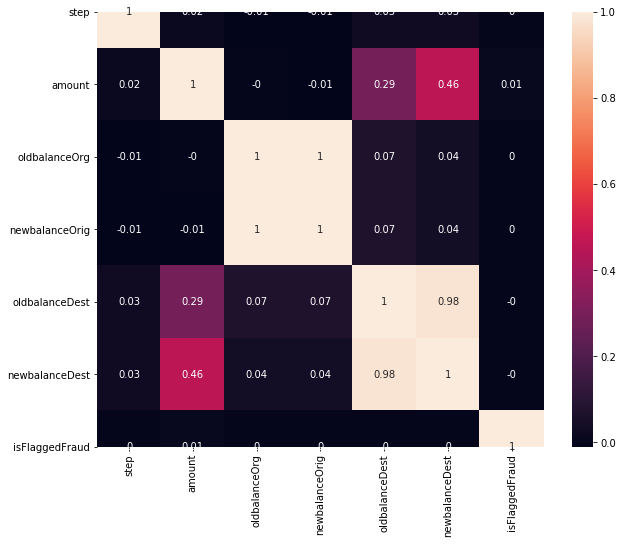

In [70]:
correlation_matrix = mydata_X.corr().round(2)
plt.subplots(figsize=(10,8))
cor = sns.heatmap(data=correlation_matrix, annot=True)

Existe una fuerte dependencia entre las variables *newbalanceOrig* y *oldbalanceOrig* y entre *newbalanceDest* y *oldbalanceDest*. Estas relaciones de dependencia lineal entre las variables tienen sentido ya que suponen el aumento/disminución del balance se realiza sobre la misma cuenta móvil. De cara a la realización del modelo predictivo, se tendrá en cuenta el resultado de la matriz de correlaciones.

### Conclusiones
Las conclusiones obtenidas en esta fase de discovery de datos han sido:
 1. La variable *isFlaggedFraud* no está considerando todas las transacciones que superan los 200.000u.m.. Generaremos una nueva variable que considere todas las transacciones que superen esta cantidad.
 2. Existen 774.269 registros que tienen los balances a cero pero la variable amount es superior a cero y no son considerados fraudulentos. Según la bibliografía, las categorías PAYMENT, TRANSFER y CASH_OUT implican variación en los balances de las cuentas origen y destino. Puesto que estos casos no cumplen con lo definido, se considerarán outliers y se eliminaran del dataframe.
 3. Existen 16 registros para los que la variable *amount* es igual a cero y la varible *oldbalacenOrg* es igual a cero, lo que supone que no se ha realizado la transferencia. Entendemos que al no haber variación en los balances ya que que la cantidad transferida es cero, los criterios de negocio consideran la transacción fraudulenta y por ello no conviene eliminarlos del dataframe.
 4. No existen registros para los que la cantidad a tranferir sea cero y el balance en la cuenta origen sea positivo
 5. Encontramos 8.008 registros que pertenecen a transacciones en las que cantidad enviada corresponde con el saldo de la cuenta origen. Entendemos que según criterios de negocio, esta casuísitica es considerada fraudulenta.
 6. Encontramos 1.512.573 registros en los que la cantidad enviada es mayor al saldo existente en la cuenta origen, de los cuáles, unicamente 4 han sido considerados fraudulentos. Puesto que la bibliografía no aporta información sobre esta casuísitca, no somos capaces de determinar cuál es el motivo para considerar unos registros como fraudulentos y otros no. Guiándonos por la experiencia, al haber una tan clara mayoría de casos que se consideran no fraudulentos, entendemos que los 4 registros están mal categorizados
 7. El saldo de las cuentas de los comerciantes (*NameDest == 'M'*) no viene informado.
 8. No existen casos en los que para una cantidad emitida de 0.0 u.m. el saldo en la cuenta destino se incremente
 9. Cuando la cantidad enviada es igual al saldo en la cuenta origen,las reglas con las que se contruyó el dataset, sí detectan esos movimientos como fraude, en cambio, cuando el amount es mayor que lo que hay en la cuenta, no se está considerando fraude. Más adelante, tomaremos una decisión sobre estas casuísticas.
 10. Vamos a crear dos nuevas variables: una para la diferencia de balances en las cuentas origen y otra para la diferencia de balances en las cuentas destino

## Exportamos el Notebook
Exportamos el Notebook a formato HTML:

In [71]:
from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = '2_discovery_datos.ipynb'
output_file_name = '2.discovery_datos.html'

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)